## Description
The other notebook does not make use of snap to road. Now I make use of snap to road results where I count the number of vehicles in either direction of the road. Again I have to reiterate that I make use of STR results.
The mapops has assured me that the SIngapore map version 2018-410 is crubbed clean in terms of DoT and road types hence I am using it as the ground truth to train classifiers.

In [1]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from xgboost import plot_importance
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import joblib
%matplotlib inline  

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Should I include road type and feature
This is a bit problamatic since road type may not be correctly identified for smaller other countries apart from SG. Hence we can only rely upon the direction stats and road length and not on the road type feature.

Major problem is that diffrent cities have different probabilities of their road types being oneway or not. For example in Singapore primary roads are overwhelmingly oneway, not so much in Jakarta. While residential roads in Singapore can be one way or bidirectional in SG but are almost overhwhelmingly bi-directional.

Now to counter this what I plan to do is give a prior for the road category of the road being oneway. This will dynamically change for different cities and act as a proxy for road type.|

In [2]:
include_road_type=False
map_version='2018-410'
city_id=6

In [3]:
data=pd.read_csv(f"data/direction_statsOct2018-{map_version}.csv")
#data=data.loc[data.roadtype!='pedestrian']
road_length=pd.read_csv(f"data/road_length_{city_id}_2018-410.csv")
data_joined=data.merge(road_length,left_on="way_id",right_on="road_id")
#data_joined.head()
data_joined=data_joined[['way_id','dir1','dir2','roadtype','road_len','oneway']]
data_joined.oneway=data_joined.oneway.map({True:1,False:0})
print(data_joined.shape)
data_joined.head()

(55737, 6)


,way_id,dir1,dir2,roadtype,road_len,oneway
0,547102905,86.0,294.0,service,128.597534,0
1,547102906,405.0,485.0,service,66.325304,0
2,547102907,553.0,347.0,service,102.951698,0
3,466885630,20.0,62.0,service,320.741785,0
4,547102903,285.0,114.0,service,180.903365,0


### Read road network data 
For prior computation

In [4]:
road_network=pd.read_csv(f"data/roads_{city_id}_{map_version}.txt",sep="\t")
#road_network.head()
one_way_counts=road_network.groupby(['road_type','is_oneway']).count()
one_way_counts.reset_index(inplace=True)
one_way_counts=one_way_counts[['road_type','is_oneway','road_id']]
one_way_counts=pd.pivot_table(one_way_counts, values='road_id', index=['road_type'],columns=['is_oneway'], aggfunc=np.sum)
one_way_counts.reset_index(inplace=True)
one_way_counts.fillna(0.0,inplace=True)
one_way_counts.rename(columns={False: 'count_bidir',True: 'count_oneway',\
                              'road_type':'roadtype'},inplace=True)
one_way_counts['prob_oneway']=one_way_counts['count_oneway']/(one_way_counts['count_oneway']+one_way_counts['count_bidir'])
one_way_counts=one_way_counts[['roadtype','prob_oneway']]
one_way_counts

is_oneway,roadtype,prob_oneway
0,living_street,0.375000
1,motorway,1.000000
2,motorway_link,0.996676
3,pedestrian,0.000000
4,primary,0.996537
5,primary_link,0.990858
6,raceway,0.583333
7,residential,0.443606
8,road,0.000000
9,secondary,0.981625


In [5]:
#prior probablity for road type being oneway
data_joined=data_joined.merge(one_way_counts,left_on="roadtype",right_on="roadtype")
data_joined.head()

,way_id,dir1,dir2,roadtype,road_len,oneway,prob_oneway
0,547102905,86.0,294.0,service,128.597534,0,0.226324
1,547102906,405.0,485.0,service,66.325304,0,0.226324
2,547102907,553.0,347.0,service,102.951698,0,0.226324
3,466885630,20.0,62.0,service,320.741785,0,0.226324
4,547102903,285.0,114.0,service,180.903365,0,0.226324


In [6]:
data_joined['num_pings']=data_joined.dir1+data_joined.dir2
data_joined['dir1_ratio']=data_joined.dir1/data_joined.num_pings
data_joined['dir2_ratio']=data_joined.dir2/data_joined.num_pings
data_joined['entropy']=-(data_joined.dir1_ratio*np.log2(data_joined.dir1_ratio)+\
                         data_joined.dir2_ratio*np.log2(data_joined.dir2_ratio))
data_joined.fillna(0.0,inplace=True)
data_joined=data_joined[["way_id","roadtype","road_len","num_pings","dir1_ratio","dir2_ratio","entropy","prob_oneway","oneway"]]
data_joined.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


,way_id,roadtype,road_len,num_pings,dir1_ratio,dir2_ratio,entropy,prob_oneway,oneway
0,547102905,service,128.597534,380.0,0.226316,0.773684,0.771533,0.226324,0
1,547102906,service,66.325304,890.0,0.455056,0.544944,0.994164,0.226324,0
2,547102907,service,102.951698,900.0,0.614444,0.385556,0.961871,0.226324,0
3,466885630,service,320.741785,82.0,0.243902,0.756098,0.801470,0.226324,0
4,547102903,service,180.903365,399.0,0.714286,0.285714,0.863121,0.226324,0


### Get test data

In [7]:
test=pd.read_csv("data/BukitBatokGT.csv")
test=test.merge(data_joined,left_on="way-id",right_on="way_id")
print(test.shape)
test=test[["way_id","roadtype_x","road_len","num_pings","dir1_ratio","dir2_ratio","entropy","prob_oneway","oneway_y"]]
test.rename(index=str, columns={"roadtype_x": "roadtype","oneway_y": "oneway"},inplace=True)
test.head()

(405, 13)


,way_id,roadtype,road_len,num_pings,dir1_ratio,dir2_ratio,entropy,prob_oneway,oneway
0,631470773,secondary,41.506191,1178.0,1.000000,0.000000,0.00000,0.981625,1
1,630435840,trunk,33.038678,5672.0,1.000000,0.000000,0.00000,0.998291,1
2,631470772,trunk,83.698292,15159.0,1.000000,0.000000,0.00000,0.998291,1
3,465466222,trunk_link,75.505376,10846.0,1.000000,0.000000,0.00000,0.993976,1
4,479356427,trunk,5.917265,46824.0,0.062254,0.937746,0.33633,0.998291,1


In [8]:
#get rid of the test data set
data_joined=data_joined[~data_joined.way_id.isin(test.way_id.tolist())]
data_joined.shape

(55355, 9)

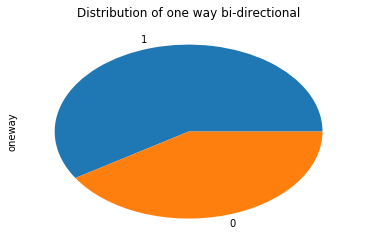

In [9]:
#data is at least reasonably balanced.
data_joined.oneway.astype('category').value_counts().\
plot(kind='pie',title='Distribution of one way bi-directional')

#### Take a look at missing values
No graph plotted means none

In [10]:
#sns.set(rc={'figure.figsize':(12,6)})
percentage_nan=data_joined.isnull().sum()/data_joined.shape[0]
percentage_nan.sort_values(inplace=True)
if percentage_nan[0]>0.0:
    percentage_nan[percentage_nan>0.0].plot('bar',title='Features with missing values')

             road_len  num_pings   entropy  prob_oneway    TARGET
road_len     1.000000   0.370337  0.093292     0.046677 -0.052870
num_pings    0.370337   1.000000 -0.103103     0.258522  0.162085
entropy      0.093292  -0.103103  1.000000    -0.511424 -0.828870
prob_oneway  0.046677   0.258522 -0.511424     1.000000  0.650274
TARGET      -0.052870   0.162085 -0.828870     0.650274  1.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


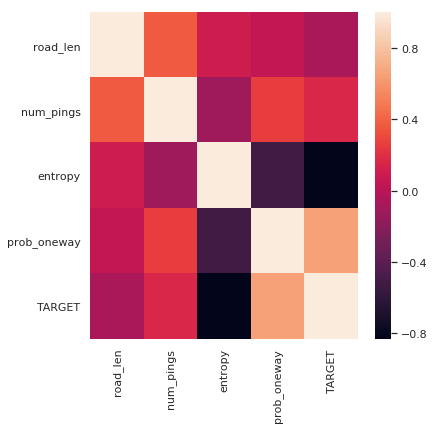

In [11]:
conti_cols=['road_len', 'num_pings', 'entropy', 'prob_oneway']
sns.set(rc={'figure.figsize':(6,6)})
df=data_joined[list(conti_cols)]
df['TARGET']=data_joined.oneway
corr = df.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)


### Combine train and test for preprocessing

In [12]:
print(data_joined.shape,test.shape)
train_test = pd.concat(objs=[data_joined, test], axis=0)
print(train_test.shape)
train_test.head()

(55355, 9) (405, 9)
(55760, 9)


,way_id,roadtype,road_len,num_pings,dir1_ratio,dir2_ratio,entropy,prob_oneway,oneway
0,547102905,service,128.597534,380.0,0.226316,0.773684,0.771533,0.226324,0
1,547102906,service,66.325304,890.0,0.455056,0.544944,0.994164,0.226324,0
2,547102907,service,102.951698,900.0,0.614444,0.385556,0.961871,0.226324,0
3,466885630,service,320.741785,82.0,0.243902,0.756098,0.801470,0.226324,0
4,547102903,service,180.903365,399.0,0.714286,0.285714,0.863121,0.226324,0


#### Scalarize continous columns

In [13]:
#for col in conti_cols:
#    std=train_test[col].std()
#    mean=train_test[col].mean()
#    train_test[col]=(train_test[col]-mean)/std

if include_road_type:
    train_test = pd.get_dummies(train_test, columns=['roadtype'])
else:
    train_test=train_test.drop(['roadtype'],axis=1)

In [14]:
train = train_test.iloc[0:data_joined.shape[0],]
test = train_test.iloc[data_joined.shape[0]:,]
print(train.shape,test.shape)

(55355, 8) (405, 8)


### Get validation and train sets
Also get the features and the output.

In [15]:
train_features=train[conti_cols]
features_arr=np.array(train_features)
train_cols=train_features.columns
print(train_cols)
print(len(train_cols))


#validation features
valid_features=test.loc[:, (test.columns != 'way_id') & (test.columns != 'oneway')&
(test.columns != 'dir1_ratio')&(test.columns != 'dir2_ratio')]
print(valid_features.columns)
print(len(valid_features.columns))
valid_features=np.array(valid_features)


#labels
y=np.array(data_joined.oneway.astype('category'))


Index(['road_len', 'num_pings', 'entropy', 'prob_oneway'], dtype='object')
4
Index(['road_len', 'num_pings', 'entropy', 'prob_oneway'], dtype='object')
4


#### Predict for test set

In [16]:
from sklearn import metrics
def compute_validation_acc(model,features_test,target_test):
    predict_proba=model.predict_proba(features_test)
    target=np.array(target_test.astype('float64'))
    pred=np.array(predict_proba[:,1])
    auc =  roc_auc_score(target,pred)
    labels=['bi-directional','oneway']
    print("accuracy score:",accuracy_score(target,model.predict(features_test)))
    cm=confusion_matrix(target,model.predict(features_test))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    
    plt.figure()
    fpr, tpr, _ = metrics.roc_curve(target,  pred)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    return auc

### Xgboost model

In [17]:
gbm = xgb.XGBClassifier(max_depth=6,n_estimators=300, learning_rate=0.05,reg_lambda=1.5,eval_metric='auc').\
fit(features_arr, y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy score: 0.9654320987654321


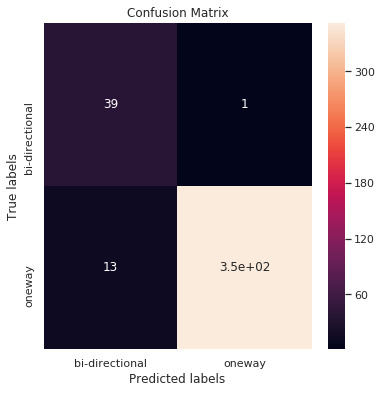

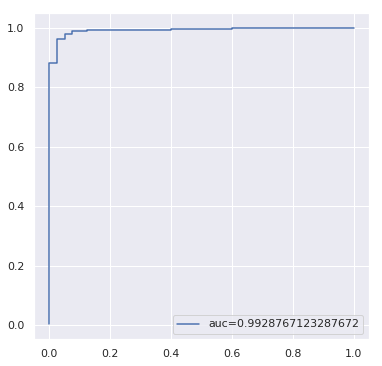

0.9928767123287672

In [18]:
compute_validation_acc(gbm,valid_features,test.oneway)

In [19]:
sorted_idx = np.argsort(gbm.feature_importances_)[::-1]
feature_importance={}
for index in sorted_idx:
    feature_importance[train_features.columns[index]]= gbm.feature_importances_[index]

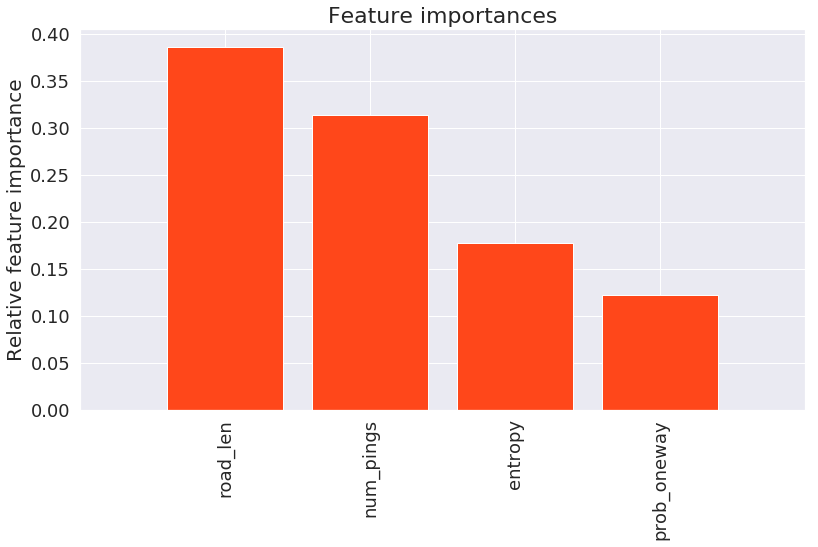

In [20]:
n_features=len(train_cols)
ss = sorted(feature_importance, key=feature_importance.get, reverse=True)
top_names = ss[0:]
f=plt.figure(figsize=(13,7))
plt.grid(True)
plt.title("Feature importances",fontsize=22)
plt.bar(range(n_features), [feature_importance[i] for i in top_names], color="#ff471a", align="center")
plt.xlim(-1, n_features)
plt.ylabel('Relative feature importance',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(range(n_features), top_names, rotation=90,fontsize=18)
f.savefig("feauture_importance.pdf", bbox_inches='tight')

### Save the trained Xgboost model

In [21]:
filename='xgboost_oneway_detector_without_road_type'
if include_road_type:
    filname='xgboost_oneway_detector_with_road_type'

joblib.dump(gbm,filename)

['xgboost_oneway_detector_without_road_type']